In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
# import sys
# sys.path.insert(0, '../')

import numpy as np
import tensorflow as tf
import data
import utils
import plot as plots
import evaluation
from model import WGanModel
from gan import CosmoGAN

# Parameters

In [7]:
ns = 32
nsamples = 500
k = 10
try_resume = True

# Data handling

Load the data

In [30]:
images, raw_images = data.load_samples(nsamples = nsamples, permute=False, k=k)
images = data.make_smaller_samples(images, ns)
raw_images = data.make_smaller_samples(raw_images, ns)   

Select 500 samples out of 15000.


Let us plot 16 images

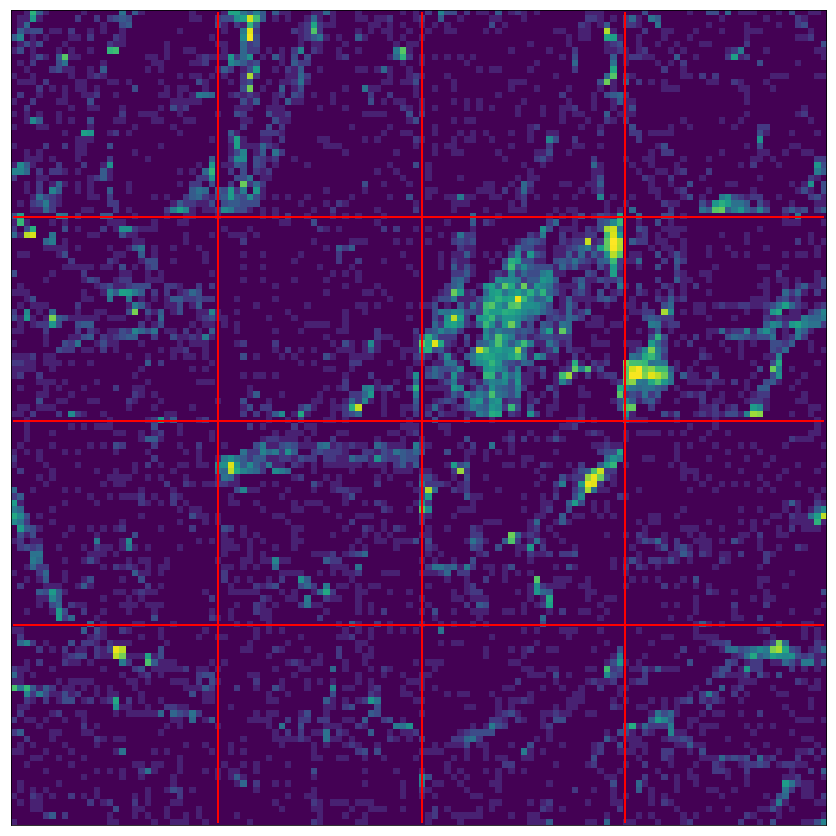

In [5]:
plt.figure(figsize=(15,15))
plots.draw_images(images,nx=4,ny=4)

# A) The WGAN

In [9]:
time_str = 'test'
global_path = '../../saved_result/'

name = 'WGAN{}'.format(ns)

## Parameters

In [12]:
bn = False

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2]
params_discriminator['nfilter'] = [16, 32, 32]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5]]
params_discriminator['batch_norm'] = [bn, bn, bn]
params_discriminator['full'] = [32]
params_discriminator['minibatch_reg'] = True
params_discriminator['summary'] = True

params_generator = dict()
params_generator['stride'] = [2, 1, 1]
params_generator['latent_dim'] = 100
params_generator['nfilter'] = [32, 64, 1]
params_generator['shape'] = [[5, 5], [5, 5], [5, 5]]
params_generator['batch_norm'] = [bn, bn]
params_generator['full'] = [16*16*32]
params_generator['summary'] = True
params_generator['non_lin'] = 'tanh'

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['batch_size'] = 32
params_optimization['gen_optimizer'] = 'rmsprop' # rmsprop / adam / sgd
params_optimization['disc_optimizer'] = 'rmsprop' # rmsprop / adam /sgd
params_optimization['disc_learning_rate'] = 3e-5
params_optimization['gen_learning_rate'] = 3e-5
params_optimization['beta1'] = 0.9
params_optimization['beta2'] = 0.999
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 10


params_cosmology = dict()
params_cosmology['clip_max_real'] = False
params_cosmology['log_clip'] = 0.1
params_cosmology['sigma_smooth'] = 1
params_cosmology['k'] = k
params_cosmology['Npsd'] = 500


params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization
params['cosmology'] = params_cosmology

params['normalize'] = False
params['image_size'] = [ns, ns]
params['prior_distribution'] = 'gaussian'
params['sum_every'] = 500
params['viz_every'] = 500
params['print_every'] = 100
params['save_every'] = 2000
params['name'] = name
params['summary_dir'] = global_path + params['name'] + '_' + time_str +'_summary/'
params['save_dir'] = global_path + params['name'] + '_' + time_str + '_checkpoints/'

In [19]:
resume, params = utils.test_resume(try_resume, params)

Resume, the training will start from the last iteration!


## Build the model

In [20]:
wgan = CosmoGAN(params, WGanModel)

Generator 
------------------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 8192 outputs
         Size of the variables: (?, 8192)
     Reshape to (?, 16, 16, 32)
     1 Deconv layer with 32 channels
         Batch norm
         Size of the variables: (?, 32, 32, 32)
     2 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 32, 32, 64)
     3 Deconv layer with 1 channels
         Size of the variables: (?, 32, 32, 1)
    Non lienarity: tanh
     The output is of size (?, 32, 32, 1)
------------------------------------------------------------

Discriminator 
------------------------------------------------------------
     The input is of size (?, 32, 32, 1)
     0 Conv layer with 16 channels
         Size of the variables: (?, 16, 16, 16)
     1 Conv layer with 32 channels
         Size of the variables: (?, 8, 8, 32)
     2 Conv layer with 32 channels
         Size of the variables: (?, 4, 4, 32)


## Train the model
Note that the input is the processed data... Maybe, we should change that

In [21]:
wgan.train(images, resume=resume)

Load weights in the nework
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../saved_result/WGAN32_test_checkpoints/WGAN32-7500
Epoch: [ 7] [ 499/1000] Counter:7500	( 0.1 min	1057.614 0.03 examples/sec	sec/batch)	L_Disc:-0.09510455	L_Gen:9.03800869
 [*] [Fake, Real] Min [0.146, 0.190],	Median [0.821,0.854],	Mean [1.898E+00,2.295E+00],	Max [3.679E+01,9.231E+01],	Var [5.387E+01,1.719E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.203, 0.200, 0.195]	CrossPS:[-0.291, -0.849, -0.085]
 [*] New PSD Low achieved 897.793517 (was 10000000000.000000)
 [*] New Log PSD Low achieved 2.457325 (was 10000.000000)
 7500 current PSD L2 897.7935167999991, logL2 2.4573247894931507
Model saved!
Epoch: [ 7] [ 599/1000] Counter:7600	( 3.1 min	17.748 1.80 examples/sec	sec/batch)	L_Disc:-0.13525407	L_Gen:10.23504829
Epoch: [ 7] [ 699/1000] Counter:7700	( 5.8 min	19.146 1.67 examples/sec	sec/batch)	L_Disc:-0.10706546	L_Gen:7.10506821
Epoch: [ 7] [ 799/1000] Counter:7800	( 8.6 min	19.236 1.6

In [45]:
gen_sample, gen_sample_raw = wgan.generate(N=500)
gen_sample = np.squeeze(gen_sample)
gen_sample_raw = np.squeeze(gen_sample_raw)

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../saved_result/WGAN32_test_checkpoints/WGAN32-10001


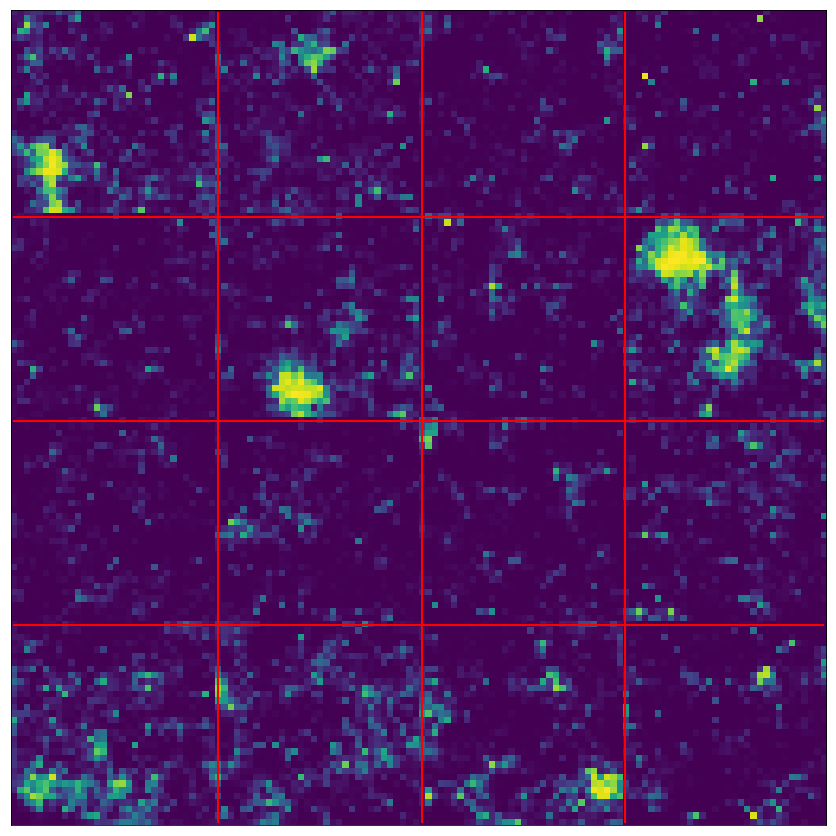

In [46]:
plt.figure(figsize=(15,15))
plots.draw_images(gen_sample,nx=4,ny=4)

Log l2 PSD loss: 5.656017364168661
L2 PSD loss: 225205.46148218322
Log l1 PSD loss: 2.2288722500289686
L1 PSD loss: 433.6704375743721


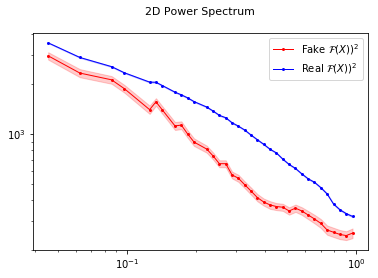

In [47]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_psd(raw_images, gen_sample_raw)

Log l2 Peak Count loss: 7.664390034562317
L2 Peak Count loss: 89.13986039838869
Log l1 Peak Count loss: 1.7681164976156343
L1 Peak Count loss: 2.7001140625


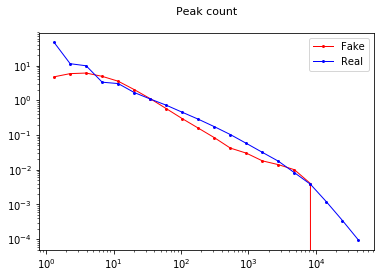

In [48]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(raw_images, gen_sample_raw)

Log l2 Mass histogram loss: 1.9131642298077025
L2 Peak Mass histogram: 1457.4452804433595
Log l1 Mass histogram loss: 1.0290348496706812
L1 Mass histogram loss: 14.021746875000002


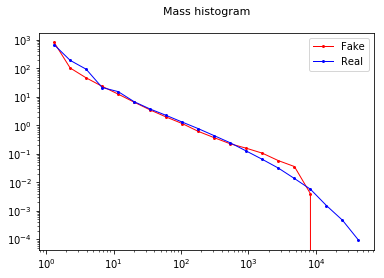

In [49]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(raw_images, gen_sample_raw)